**Import of the needed libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from librosa import load, get_duration
from librosa.feature import mfcc

pd.set_option('display.max_colwidth', None)

**Definition of the functions to compute MFCC and plot the duration of audio files**

In [2]:
def compute_mfcc_from_paths(audio_paths, n=10):
    mfccs = []
    for audio_path in audio_paths:
        y, sr = load(audio_path)
        curr_mfcc = mfcc(y=y, sr=sr, n_mfcc=n)
        mfccs.append(pd.Series(np.mean(curr_mfcc,axis=1), index=[f"mean_{i}" for i in range(n)]))
    return mfccs
    
def plot_audio_durations(audio_paths):
    durations = []

    for path in audio_paths:
        y, sr = load(path, sr=None)
        duration = get_duration(y=y, sr=sr)
        durations.append(duration)

    plt.figure()
    plt.bar(range(len(durations)), durations)
    plt.xlabel("Audio Files")
    plt.ylabel("Duration (seconds)")
    plt.title("Audio File Durations")
    plt.show()

**Dataframes acquisition and first inspection of the values**

The number of missing values in df_dev is: 0
The number of missing values in df_eval is: 0


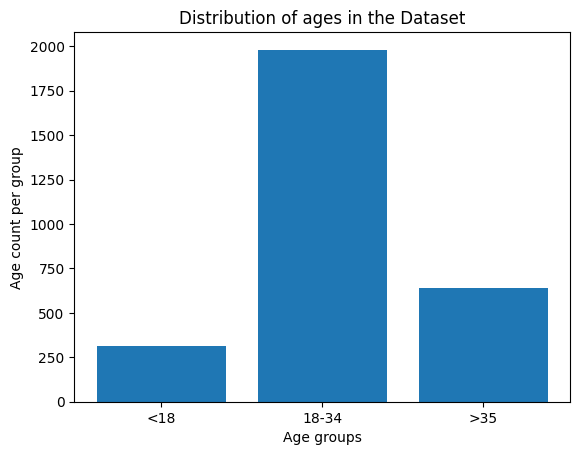

In [ ]:
df_dev = pd.read_csv("development.csv", index_col=0)
df_eval = pd.read_csv("evaluation.csv", index_col=0)

print(f"The number of missing values in df_dev is: {df_dev.isna().sum().sum()}")
print(f"The number of missing values in df_eval is: {df_eval.isna().sum().sum()}")

under_18 = df_dev[df_dev["age"] < 18]["age"].count()
between_18_35 = df_dev[(df_dev["age"] >= 18) & (df_dev["age"] < 35)]["age"].count()
over_35 = df_dev[df_dev["age"] >= 35]["age"].count()
ages_counts = [under_18, between_18_35, over_35]
ages_groups = ["<18","18-34",">35"]

plt.figure()
plt.bar(ages_groups,ages_counts)
plt.title("Distribution of ages in the Dataset")
plt.ylabel("Age count per group")
plt.xlabel("Age groups")
plt.show()

plot_audio_durations(df_dev["path"].values) #we plot the durations of audio in the df_dev

corr_df = df_dev[df_dev.select_dtypes(exclude=object).columns].corr()
print(corr_df.loc[["num_words","num_characters"],["num_words","num_characters"]])

print(f"Categorical features are: {df_dev.select_dtypes(exclude=np.number).columns}")

df = pd.concat([df_dev,df_eval], sort=False) #stack the dev and eval dataframes to work on both simultaneously
mask = df["age"].isna() #creates a mask to distinguish the two dataframes

**Data cleaning operations and dropping of unuseful features**

In [ ]:
print(f"Values in gender column: {df['gender'].unique()}")
df.loc[df["gender"]=="famale","gender"]="female" #correction of wrong data in the gender column
df = pd.get_dummies(df, columns=["gender"]) #one hot encoding on gender column

print(f"Total number of ethnicities: {len(df["ethnicity"].unique())}")
    
set_a = set(df_eval["ethnicity"].values)
print(f"Total number of ethnicities in df_eval: {len(set_a)}")
set_b = set(df_dev["ethnicity"].values)
print(f"Total number of ethnicities in df_dev: {len(set_b)}")
set_c = set_a-set_b #ethnicities that are in df_eval but not in df_dev
print(f"Total number of ethnicities in df_eval but not in df_dev: {len(set_c)}")

print(f"Total number of records in df_eval having an ethnicity not present in df_dev: {df_eval[df_eval["ethnicity"].isin(set_c)].shape[0]}") #430 records having an ethnicity not in df_dev

df["tempo"] = [float(val.rstrip("]").lstrip("[")) for val in df["tempo"]] #formatting of the tempo feature

paths = df["path"].values
df = df.drop(columns=["sampling_rate","path","ethnicity","min_pitch","max_pitch","num_characters"]) #dropping the unuseful columns

**Tuning for the ideal number of mean MFCC to compute**

In [ ]:
n_coeff = [i for i in range(5,16)]
res_ranfor = []
res_mlp = []
for i in n_coeff:
    df_mfccs = pd.DataFrame(compute_mfcc_from_paths(paths,i),index=df.index)
    df = pd.concat([df, df_mfccs],axis=1)
    X = df[~mask].drop(columns=["age"]).values
    Y = df[~mask]["age"].values
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
        
    ranfor = RandomForestRegressor(random_state=42)
    ranfor.fit(x_train,y_train)
    y_pred = ranfor.predict(x_test)
    res_ranfor.append(root_mean_squared_error(y_test,y_pred))

    mlpreg = MLPRegressor((100,),random_state=42,max_iter=2000)
    mlpreg.fit(x_train,y_train)
    y_pred = mlpreg.predict(x_test)
    res_mlp.append(root_mean_squared_error(y_test,y_pred))

    df = df.drop(columns=df_mfccs.columns)

plt.figure()
plt.plot(n_coeff,res_ranfor,color="blue",label="RandomForestRegressor")
plt.plot(n_coeff,res_mlp,color="red",label="MLPregressor")
plt.legend()
plt.xlabel("Number of MFCC Coefficients")
plt.ylabel("RMSE")
plt.title("Regression RMSE for Different n_coeff")
plt.show()

df_mfccs = pd.DataFrame(compute_mfcc_from_paths(paths),index=df.index)
df = pd.concat([df, df_mfccs],axis=1)

**PCA for the MLPregressor**

In [ ]:
X = df[~mask].drop(columns=["age"]).values
Y = df[~mask]["age"].values
X_eval = df[mask].drop(columns=["age"]).values

scaler = StandardScaler()
x_std = scaler.fit_transform(X)
pca = PCA()
pca.fit(x_std)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(0.9)
plt.axvline(11)
plt.title("Cumulative explained variance w.r.t. Principal Components number")
plt.xticks(range(pca.n_features_in_),labels=[f"PC{i+1}" for i in range(pca.n_features_in_)])
plt.xlabel("Principal Components")
plt.ylabel("Cumulative explained variance")
plt.show()

**GridSearch with cross validation for Hyperparameters tuning for both models**

In [ ]:
parameter_grid_ranfor = {
    "n_estimators": [100, 250, 500, 650],
    "criterion": ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    "max_features": ["sqrt", "log2"],
    "min_impurity_decrease": [0,0.01,0.001],
    "min_samples_leaf": [1,5,10],
    "random_state": [42],
    "n_jobs": [-1],
}

gs = GridSearchCV(RandomForestRegressor(),param_grid=parameter_grid_ranfor,cv=5,scoring="neg_root_mean_squared_error",n_jobs=-1)
gs.fit(X,Y)

results = pd.DataFrame(gs.cv_results_)
best_10_scores = results[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head(10)
print(best_10_scores)

pipeline = Pipeline([
                ('std', StandardScaler()),
                ('pca', PCA(12)),
                ('mlp', MLPRegressor())
            ])

parameter_grid_pipeline = {
    "mlp__hidden_layer_sizes": [(100,),(100, 50),(150,100,50)],
    "mlp__activation": ['relu', 'identity', 'logistic', 'tanh'],
    "mlp__solver": ['sgd', 'adam'],
    "mlp__learning_rate": ['constant', 'invscaling', 'adaptive'],
    "mlp__max_iter": [7000],
    "mlp__random_state": [42]
}

gs = GridSearchCV(pipeline,param_grid=parameter_grid_pipeline,cv=5,scoring="neg_root_mean_squared_error", n_jobs=-1)
gs.fit(X,Y)

results = pd.DataFrame(gs.cv_results_)
best_10_scores = results[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head(10)
print(best_10_scores)

**Final models building and submission**

In [ ]:
random_forest = RandomForestRegressor(n_estimators=650, criterion="poisson", max_features="sqrt", min_impurity_decrease=0.001, min_samples_leaf=5)
random_forest.fit(X,Y)
y_pred = random_forest.predict(X_eval)
df_eval["Predicted"]=y_pred
df_eval["Predicted"].to_csv("out_random_forest.csv",index_label="Id")

df_eval = df_eval.drop(columns=["Predicted"])

pipeline = Pipeline([
                ('std', StandardScaler()),
                ('pca', PCA(12)),
                ('mlp', MLPRegressor(hidden_layer_sizes=(150,100,50), 
                        activation="relu", solver="sgd", learning_rate="invscaling", max_iter=7000))
                    ])
pipeline.fit(X,Y)
y_pred = pipeline.predict(X_eval)
df_eval["Predicted"]=y_pred
df_eval["Predicted"].to_csv("out_pipeline.csv",index_label="Id")